In [34]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
filter_benchs = (
    pl.read_csv("group.csv")
    .select("dataset_size", "tool", "cpu_count", "time_in_seconds")
    .with_columns(pl.col("dataset_size").str.replace("MB", "").str.to_integer(), pl.col("tool").str.split("-").list.get(0))
)
grouped_filter_benchs = (
    filter_benchs.group_by("dataset_size", "tool", "cpu_count")
    .mean()
    .sort(by=["tool", "dataset_size"])
)
grouped_filter_benchs.head(10)

dataset_size,tool,cpu_count,time_in_seconds
i64,str,i64,f64
200,"""dask""",20,7.6906
200,"""dask""",1,7.675157
400,"""dask""",20,16.655072
400,"""dask""",1,16.671747
800,"""dask""",20,27.278071
800,"""dask""",1,27.070162
1600,"""dask""",20,55.123494
1600,"""dask""",1,55.185024
3200,"""dask""",1,156.585564


In [3]:
grouped_filter_benchs.filter(pl.col("cpu_count") != 1)

dataset_size,tool,cpu_count,time_in_seconds
i64,str,i64,f64
200,"""dask""",20,7.6906
400,"""dask""",20,16.655072
800,"""dask""",20,27.278071
1600,"""dask""",20,55.123494
3200,"""dask""",20,158.372624
…,…,…,…
200,"""pyspark""",20,2.433473
400,"""pyspark""",20,2.998538
800,"""pyspark""",20,3.704956


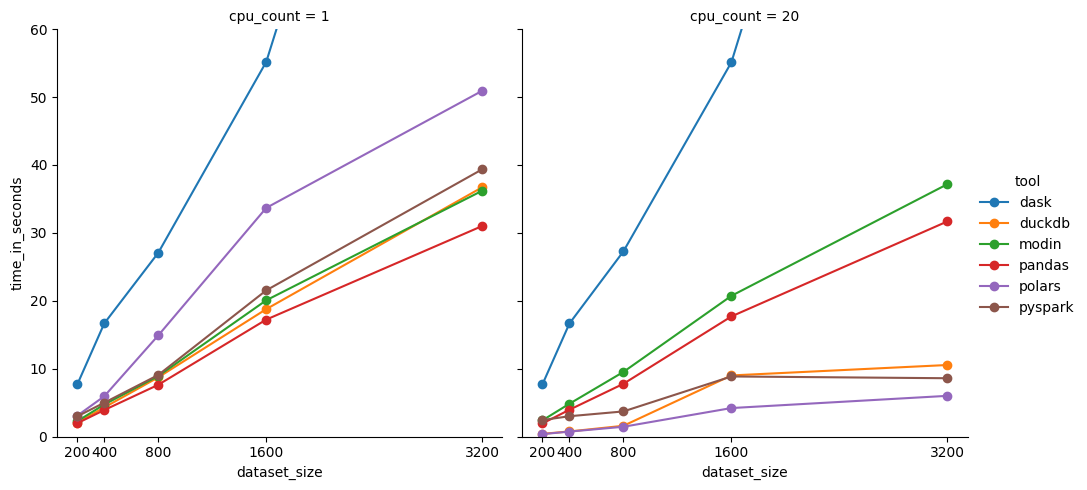

In [16]:
grid = sns.FacetGrid(grouped_filter_benchs, col="cpu_count", hue="tool", col_wrap=2, height=5)
grid.map(plt.plot, "dataset_size", "time_in_seconds", marker="o")
grid.set(xticks=grouped_filter_benchs.unique("dataset_size").to_series().sort(), ylim=(0, 60))
grid.add_legend()
# grid.set(xticks=np.arange(5), yticks=[-3, 3],
#          xlim=(-.5, 4.5), ylim=(-3.5, 3.5))
# grid.fig.tight_layout(w_pad=1)

In [69]:
def build_grid(
    benchmarks_path: str,
    ylimit: int = 60,
    y_column: str = "mean",
    ignore_first_x: bool = False,
):
    benchmarks = (
        pl.read_csv(benchmarks_path)
        .select("dataset_size", "tool", "cpu_count", "time_in_seconds")
        .with_columns(
            pl.col("dataset_size").str.replace("MB", "").str.to_integer(),
            pl.col("tool").str.split("-").list.get(0),
        )
    )
    grouped_benchmarks = (
        benchmarks.group_by("dataset_size", "tool", "cpu_count")
        .agg(
            min=pl.min("time_in_seconds"),
            max=pl.max("time_in_seconds"),
            mean=pl.mean("time_in_seconds"),
        )
        .sort(by=["tool", "dataset_size"])
        .rename({"cpu_count": "Количество потоков", "tool": "Библиотека"})
    )
    grid = sns.FacetGrid(
        grouped_benchmarks,
        col="Количество потоков",
        hue="Библиотека",
        col_wrap=2,
        height=6,
        aspect=2,
        hue_order=["polars", "pandas", "duckdb", "pyspark", "modin"],
    )

    def plot(x, y, color, **kwargs):
        plt.plot(x, y, **kwargs)
        plt.grid(True)

    grid.map(plot, "dataset_size", y_column, marker="o")
    xticks = grouped_benchmarks.unique("dataset_size").to_series().sort()
    grid.set(
        xticks=xticks[1:] if ignore_first_x else xticks,
        ylim=(0, ylimit),
        autoscale_on=True,
        xlabel="Размер Датасета (МБ)",
        ylabel="Время выполнения (сек)",
    )
    grid.tick_params("x", rotation=45)
    grid.add_legend()

In [52]:
def build_difference_grid(benchmarks_path: str, ylimit: int = 10):
    benchmarks = (
        pl.read_csv(benchmarks_path)
        .select("dataset_size", "tool", "cpu_count", "time_in_seconds")
        .with_columns(
            pl.col("dataset_size").str.replace("MB", "").str.to_integer(),
            pl.col("tool").str.split("-").list.get(0),
        )
    )
    grouped_benchmarks = (
        benchmarks.group_by("dataset_size", "tool", "cpu_count")
        .agg(min=pl.min("time_in_seconds"), max=pl.max("time_in_seconds"))
        .sort(by=["tool", "dataset_size"])
        .with_columns((pl.col("max") - pl.col("min")).alias("difference"))
    )
    grid = sns.FacetGrid(
        grouped_benchmarks, col="cpu_count", hue="tool", col_wrap=2, height=10, aspect=2
    )
    
    def plot(x, y, color, **kwargs):
        plt.plot(x, y, **kwargs)
        plt.grid(True)
        
    grid.map(plot, "dataset_size", "difference", marker="o")
    grid.set(
        xticks=grouped_benchmarks.unique("dataset_size").to_series().sort(),
        ylim=(0, ylimit),
    )
    grid.add_legend()

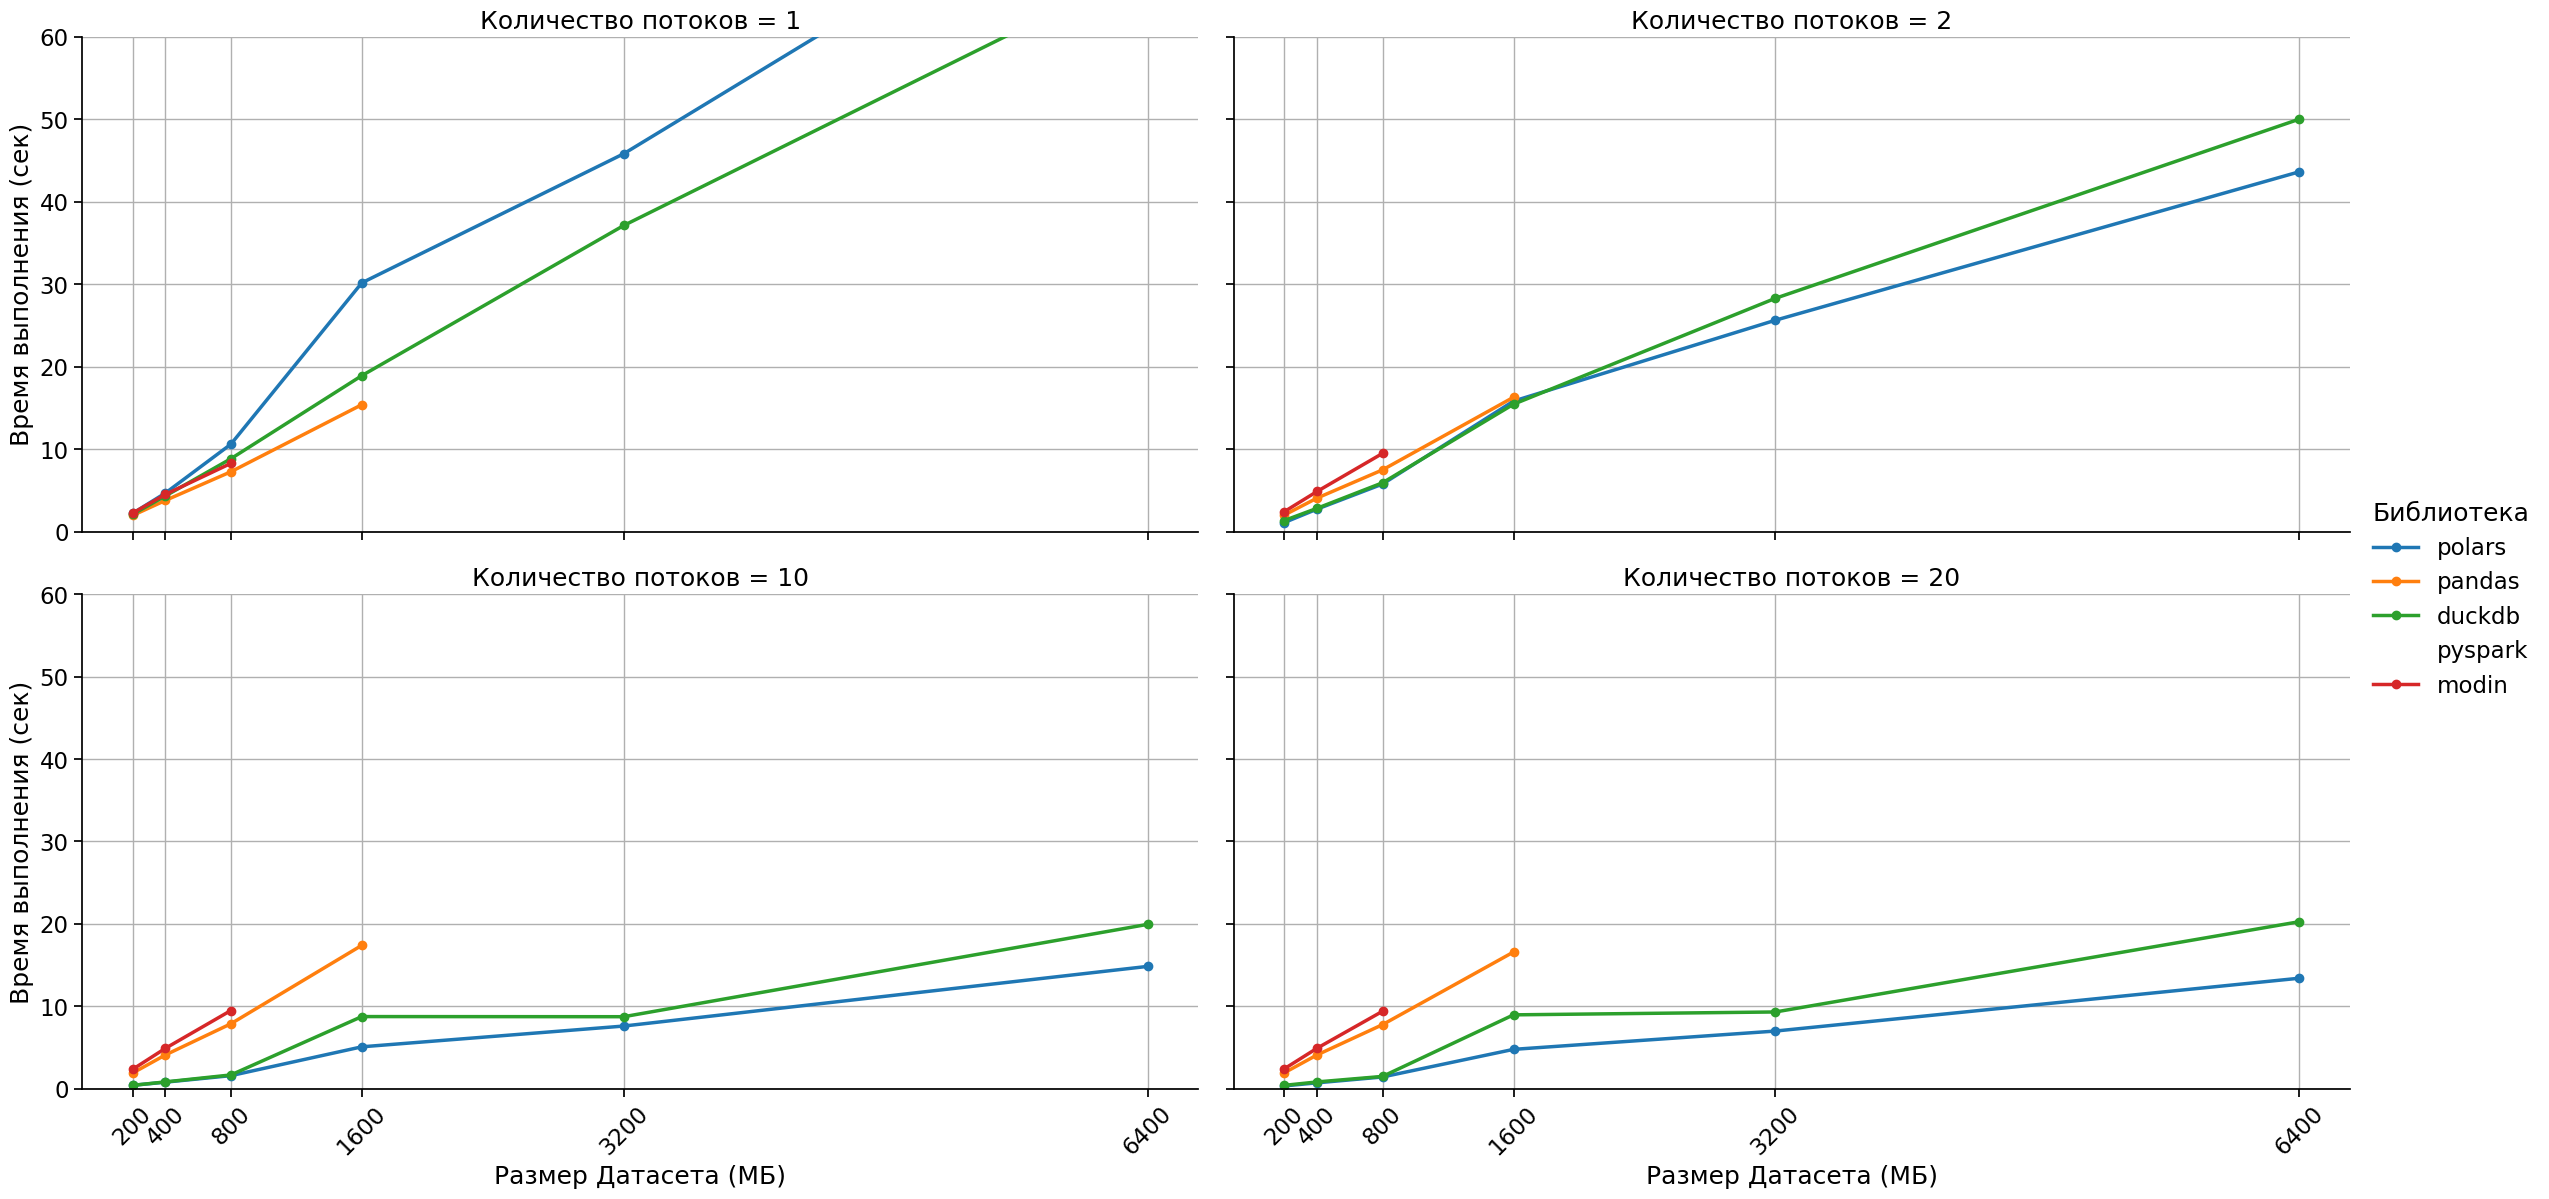

In [76]:
build_grid("group.csv")

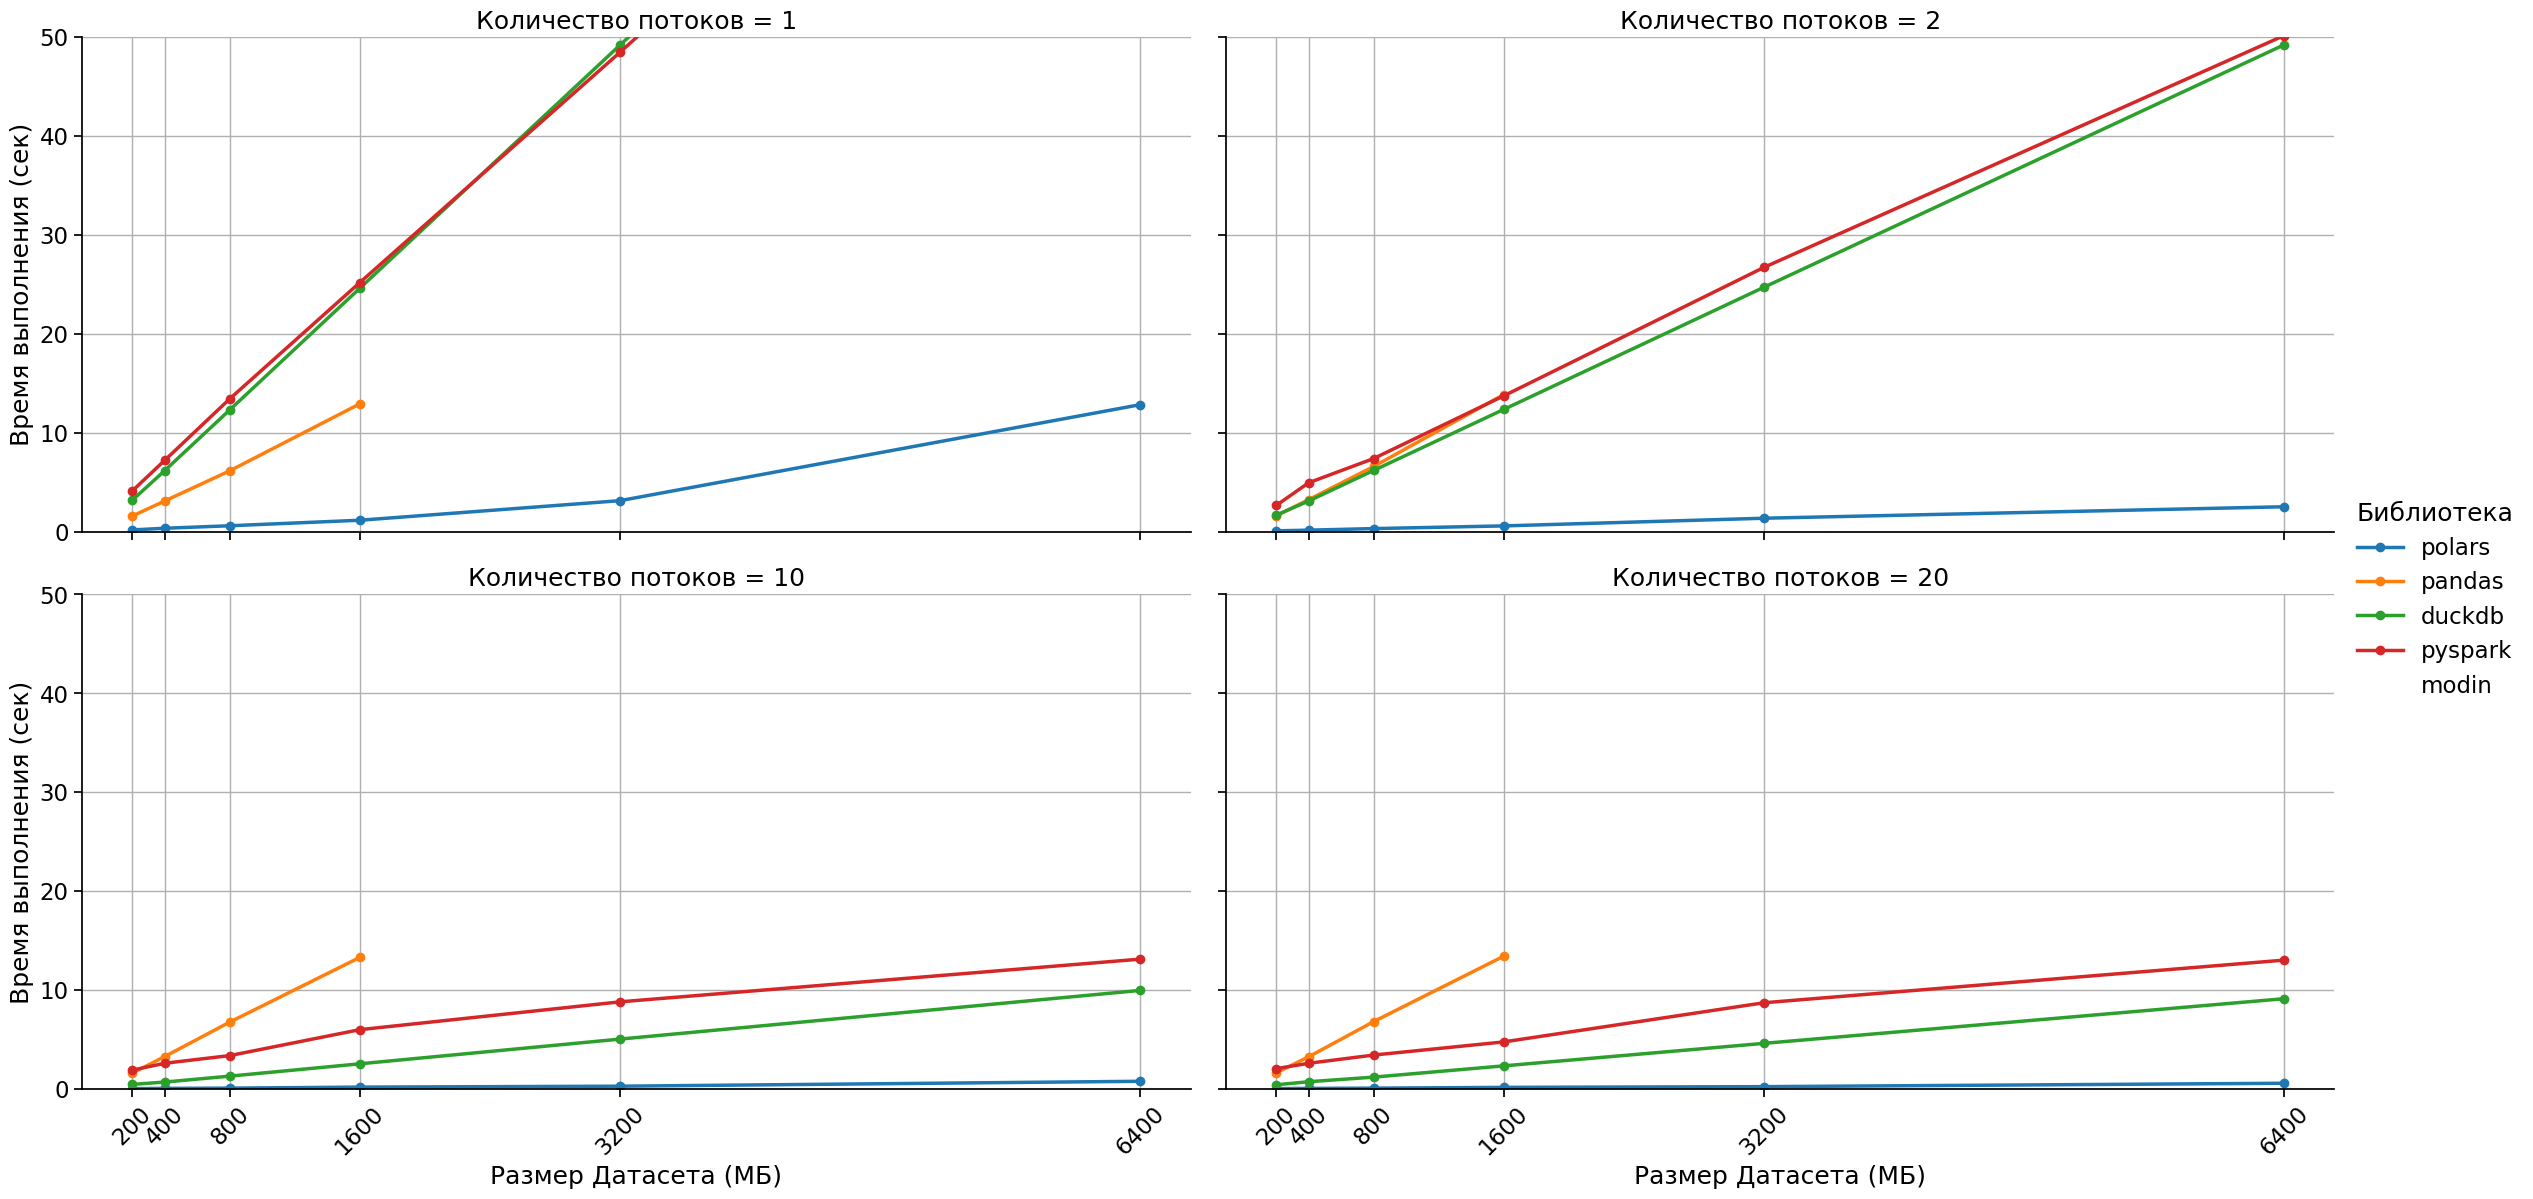

In [70]:
build_grid("filter.csv", 50)

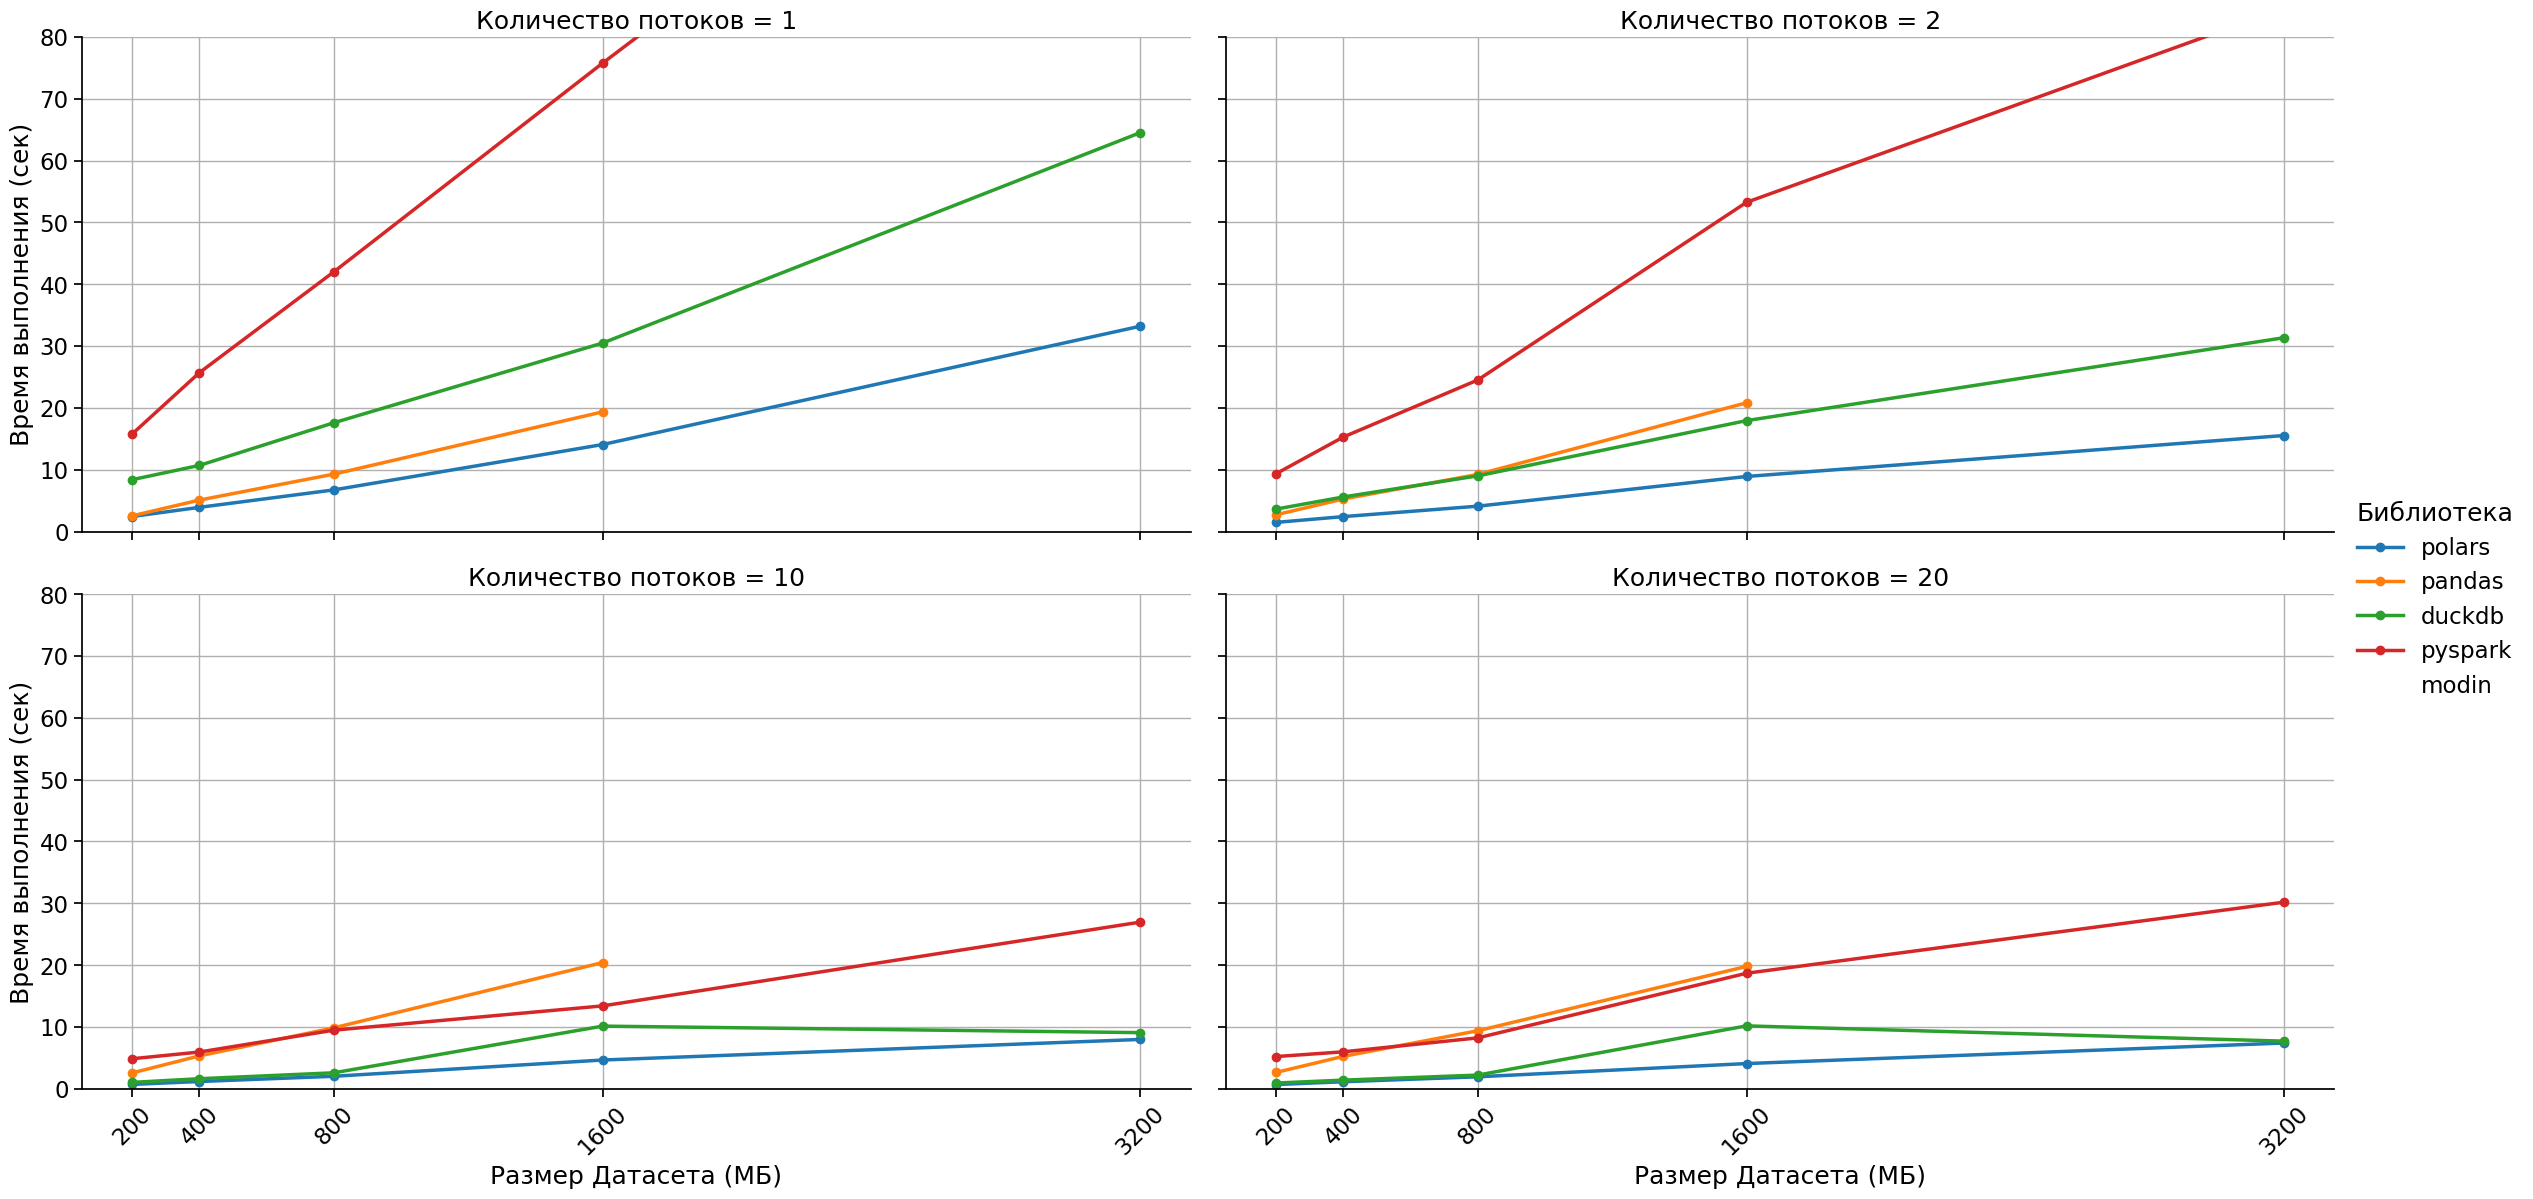

In [72]:
build_grid("join.csv", 80)

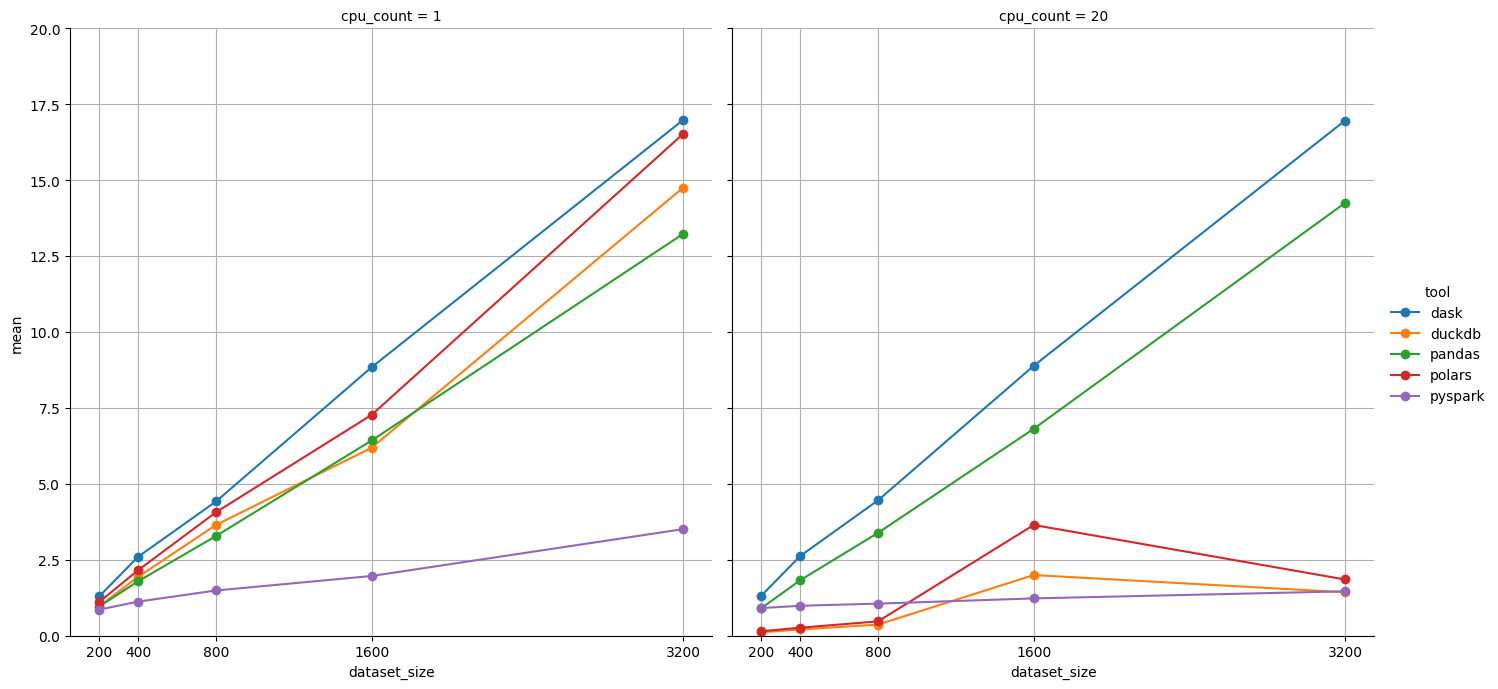

In [12]:
build_grid("is_in.csv", 20)

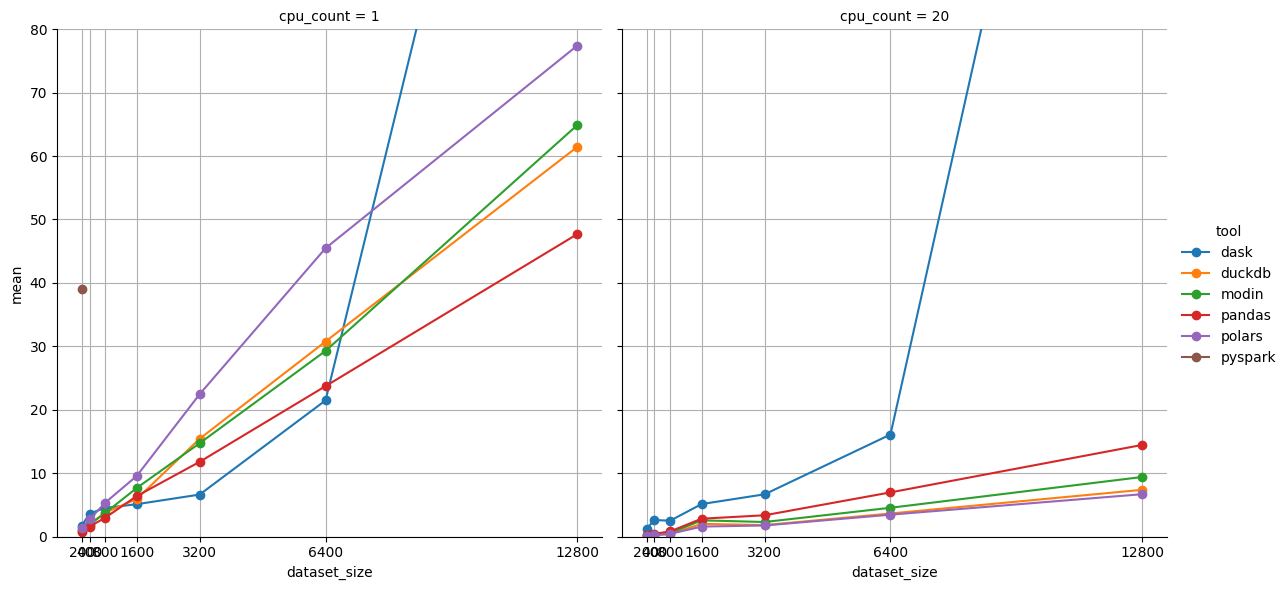

In [5]:
build_grid("read_parquet.csv", 80)

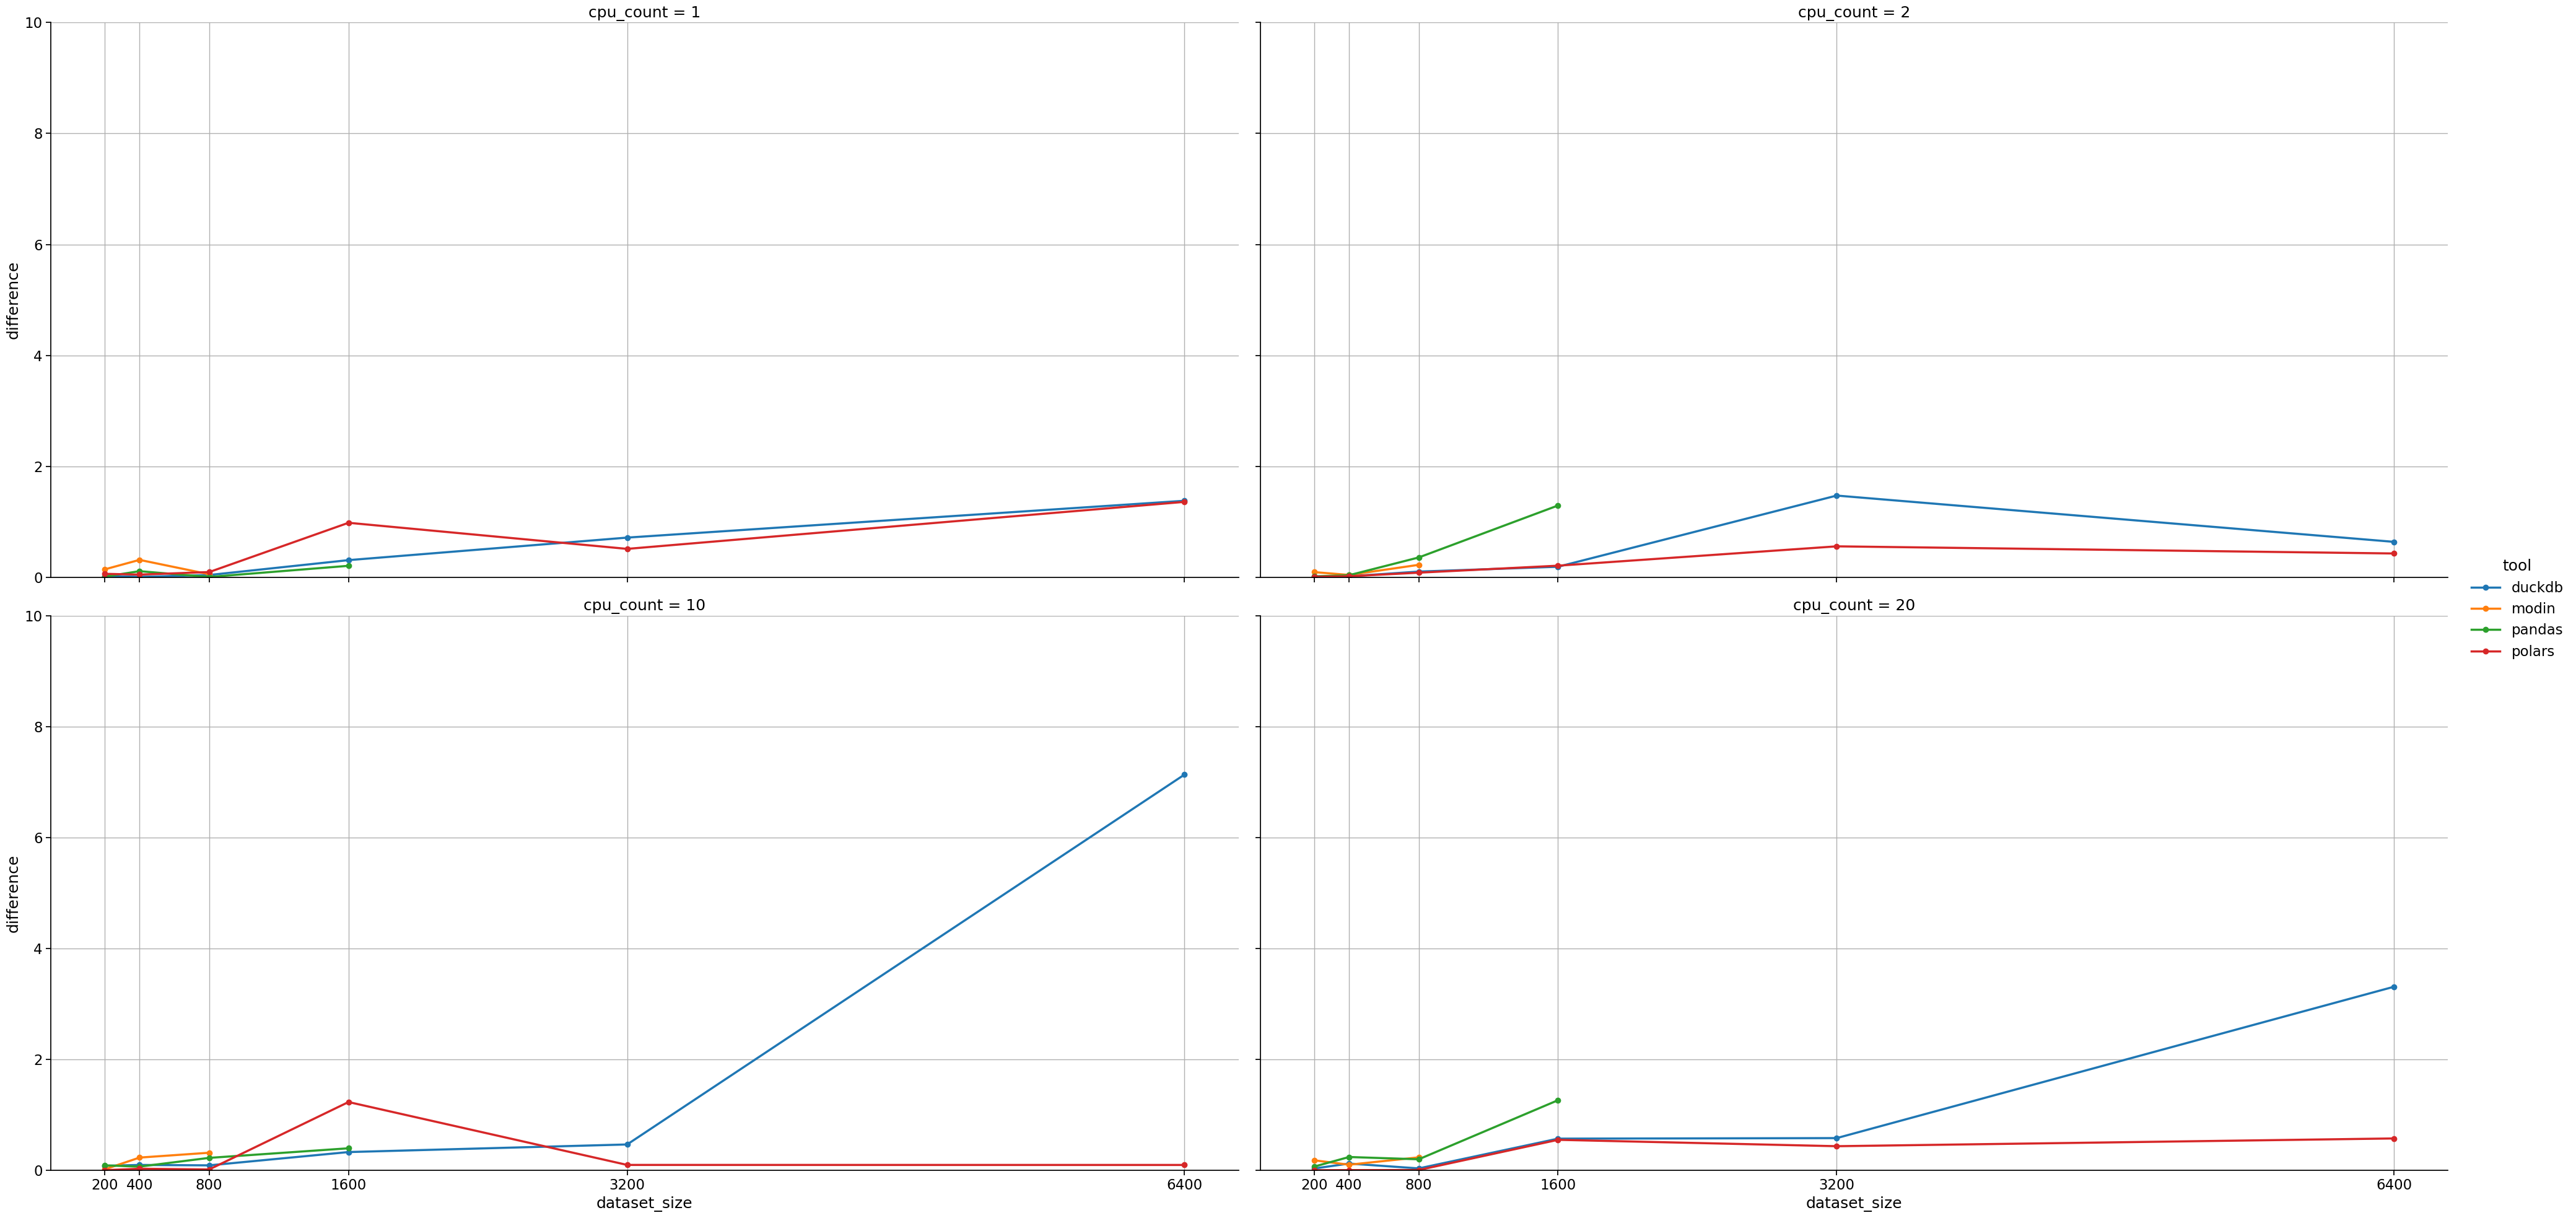

In [75]:
build_difference_grid("group.csv")

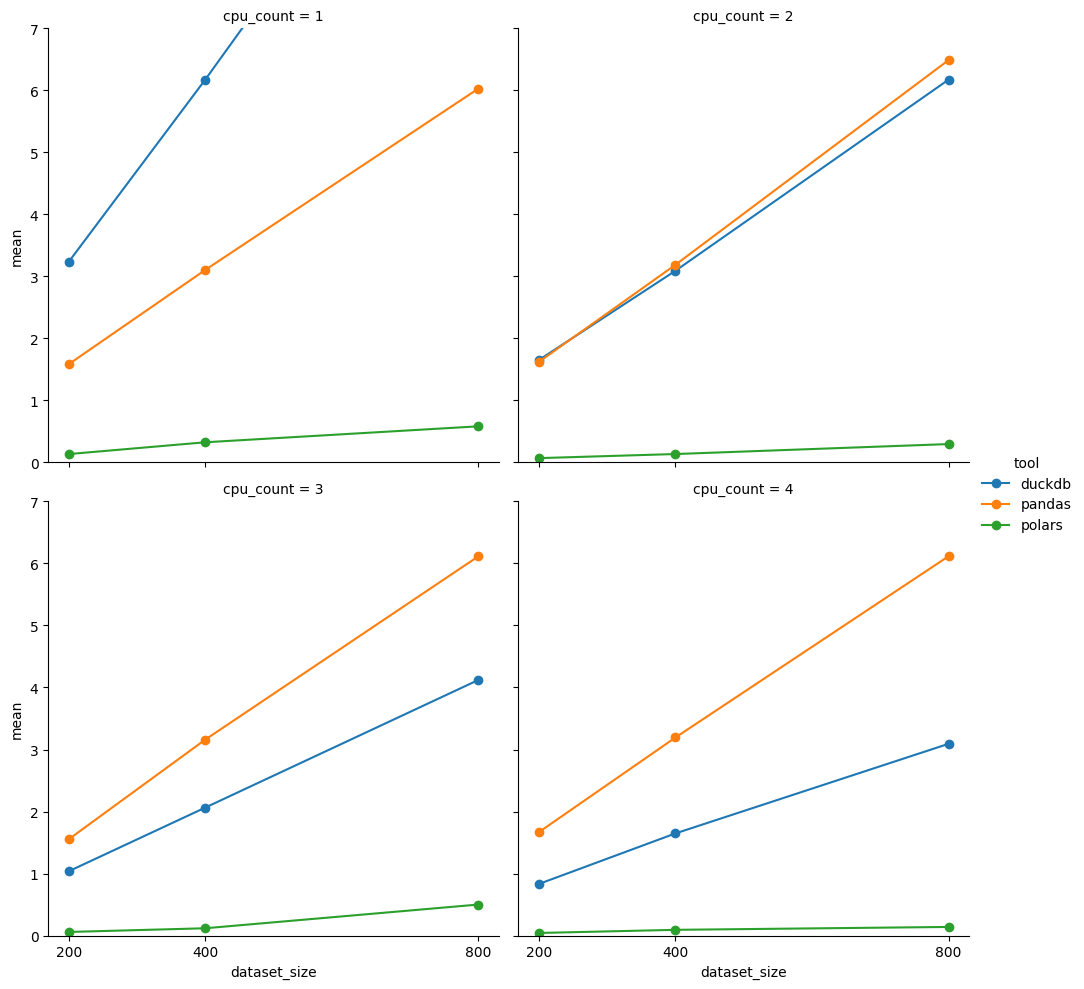

In [10]:
build_grid("filter-1_2.csv", 7)